In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


In [2]:
batch_size = 64
img_height = 180
img_width = 180

#El tamaño de la imagen es de 180x180 pixeles y el batch size es de 64
#para definir el batch size se debe tener en cuenta la memoria RAM del equipo, ya que es el numero de imagenes con las que se trabajaran POR ITERACION 


In [3]:
#nwe hace referencia a la ruta del directorio donde se encuentran las imagenes o el dataset

nwe = './dataset/entrenamiento'

#Aca se cargan las imagenes para el entrenamiento
train_ds = tf.keras.utils.image_dataset_from_directory(
  nwe,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  nwe,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 500 files belonging to 10 classes.
Using 400 files for training.
Found 500 files belonging to 10 classes.
Using 100 files for validation.


In [4]:
#IMPORTANTE EJECUTAR para obtener el nombre de las clases
class_names = train_ds.class_names
print(class_names)

['corazon', 'cubo', 'diente', 'fruta', 'gusano', 'huevo', 'mango', 'pandita', 'pinguino', 'tiburon']


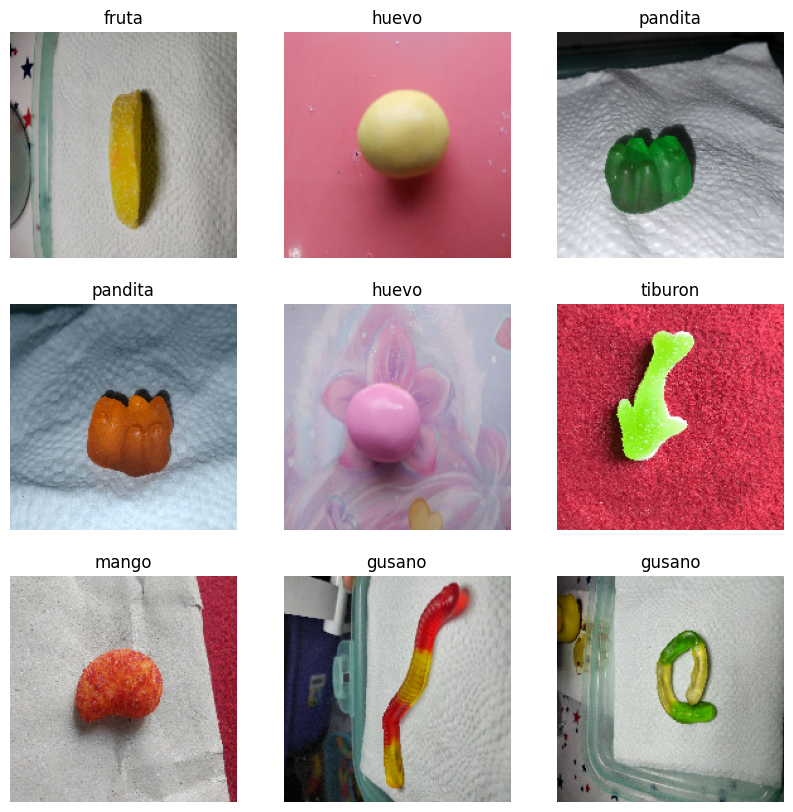

In [5]:
#Esto es opcional, solo para ver las imagenes que tenemos en nuestro dataset
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
    

In [6]:
#Esto es relativo, en nuestro caso estamos usando un modelo que si requiere un aumento de datos, entonces hay que ejecutarlo

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
  ]
)


C:\Users\Enrique Farrera\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:18: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
#info de las imagenes
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break


(64, 180, 180, 3)
(64,)


In [8]:

AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [9]:
#normalizacion de datos

normalization_layer = layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image), np.max(first_image))


0.0 1.0


In [10]:
#construcion del modelo


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from keras.models import load_model


# Cargar el modelo guardado en formato h5
# model_path = 'ruta_del_modelo/modelo.h5'
# loaded_model = load_model(model_path)

num_classes = len(class_names)
# Definir la arquitectura del modelo
model = keras.Sequential([
    # Capa de aumento de datos para aumentar la cantidad de datos de entrenamiento
    data_augmentation,
    
    # Capa de escala para normalizar los valores de píxeles de las imágenes
    layers.Rescaling(1./255),
    
    # Primera capa convolucional con 16 filtros de 3x3 y activación ReLU
    layers.Conv2D(16, 3, activation='relu', padding='same'),
    
    # Capa de Max Pooling para reducir el tamaño espacial de las representaciones
    layers.MaxPooling2D(),
    
    # Segunda capa convolucional con 32 filtros de 3x3 y activación ReLU
    layers.Conv2D(32, 3, activation='relu', padding='same'),
    
    # Otra capa de Max Pooling para reducir aún más el tamaño espacial
    layers.MaxPooling2D(),
    
    # Capa de aplanamiento para convertir los mapas de características en un vector unidimensional
    layers.Flatten(),
    
    # Primera capa densamente conectada con 50 neuronas y activación ReLU
    layers.Dense(50, activation='relu'),
    
    # Capa de salida con 10 neuronas para la clasificación de múltiples clases y activación softmax
    layers.Dense(10, activation='softmax')
])


In [11]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [12]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
epochs=400

#Si se prefiere usar un modelo h5 se puede cargar con el siguiente código. Descomentar y cambiar la ruta del modelo
# model_trained_path= './modelo.h5'
# model_trained = load_model(model_trained_path)
#y para asegurar su uso, simplemente se cambia el nombre de la variable model por model_trained

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


Epoch 1/400


C:\Users\Enrique Farrera\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\backend\tensorflow\nn.py:625: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 721ms/step - accuracy: 0.0872 - loss: 4.0387 - val_accuracy: 0.0900 - val_loss: 2.3553
Epoch 2/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 445ms/step - accuracy: 0.1184 - loss: 2.3147 - val_accuracy: 0.1400 - val_loss: 2.2822
Epoch 3/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 364ms/step - accuracy: 0.1146 - loss: 2.2793 - val_accuracy: 0.2000 - val_loss: 2.2776
Epoch 4/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 364ms/step - accuracy: 0.1408 - loss: 2.2733 - val_accuracy: 0.1200 - val_loss: 2.2574
Epoch 5/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 363ms/step - accuracy: 0.1595 - loss: 2.2343 - val_accuracy: 0.1700 - val_loss: 2.2019
Epoch 6/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 359ms/step - accuracy: 0.1935 - loss: 2.2104 - val_accuracy: 0.2700 - val_loss: 2.1191
Epoch 7/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 415ms/step - accuracy: 0.2812 - loss: 2.0925 - val_accuracy: 0.3000 - val_loss: 2.0455
Epoch 8/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 377ms/step - accuracy: 0.2951 - loss: 2.0794 - val_accuracy: 0.3100 - val_loss: 2.0

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 417ms/step - accuracy: 0.8886 - loss: 0.3577 - val_accuracy: 0.9000 - val_loss: 0.3425
Epoch 52/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 458ms/step - accuracy: 0.9075 - loss: 0.2906 - val_accuracy: 0.8800 - val_loss: 0.3638
Epoch 53/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 406ms/step - accuracy: 0.8731 - loss: 0.3693 - val_accuracy: 0.9100 - val_loss: 0.3300
Epoch 54/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 410ms/step - accuracy: 0.8812 - loss: 0.3436 - val_accuracy: 0.8600 - val_loss: 0.3509
Epoch 55/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 420ms/step - accuracy: 0.9103 - loss: 0.2884 - val_accuracy: 0.9100 - val_loss: 0.2706
Epoch 56/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 414ms/step - accuracy: 0.8766 - loss: 0.3214 - val_accuracy: 0.8800 - val_loss: 0.3186
Epoch 57/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 418ms/step - accuracy: 0.8695 - loss: 0.3629 - val_accuracy: 0.8800 - val_loss: 0.3404
Epoch 58/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 449ms/step - accuracy: 0.9071 - loss: 0.2786 - val_accuracy: 0.8900 - val_lo

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 435ms/step - accuracy: 0.9569 - loss: 0.1388 - val_accuracy: 0.8900 - val_loss: 0.2732
Epoch 102/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 458ms/step - accuracy: 0.9684 - loss: 0.1109 - val_accuracy: 0.8800 - val_loss: 0.2305
Epoch 103/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 401ms/step - accuracy: 0.9569 - loss: 0.1140 - val_accuracy: 0.9500 - val_loss: 0.1796
Epoch 104/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 403ms/step - accuracy: 0.9721 - loss: 0.0953 - val_accuracy: 0.9400 - val_loss: 0.1600
Epoch 105/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 450ms/step - accuracy: 0.9843 - loss: 0.0854 - val_accuracy: 0.9100 - val_loss: 0.1475
Epoch 106/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 418ms/step - accuracy: 0.9721 - loss: 0.0921 - val_accuracy: 0.9400 - val_loss: 0.1686
Epoch 107/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 431ms/step - accuracy: 0.9889 - loss: 0.0672 - val_accuracy: 0.9400 - val_loss: 0.1598
Epoch 108/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 420ms/step - accuracy: 0.9842 - loss: 0.0740 - val_accuracy: 0.9300 -

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 575ms/step - accuracy: 0.9817 - loss: 0.0512 - val_accuracy: 0.9700 - val_loss: 0.1005
Epoch 152/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 764ms/step - accuracy: 0.9894 - loss: 0.0454 - val_accuracy: 0.9700 - val_loss: 0.0903
Epoch 153/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 533ms/step - accuracy: 0.9980 - loss: 0.0306 - val_accuracy: 0.9600 - val_loss: 0.1214
Epoch 154/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 628ms/step - accuracy: 0.9866 - loss: 0.0480 - val_accuracy: 0.9600 - val_loss: 0.1204
Epoch 155/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 591ms/step - accuracy: 0.9765 - loss: 0.0643 - val_accuracy: 0.9500 - val_loss: 0.1401
Epoch 156/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 555ms/step - accuracy: 0.9745 - loss: 0.0734 - val_accuracy: 0.9500 - val_loss: 0.1222
Epoch 157/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 537ms/step - accuracy: 0.9781 - loss: 0.0688 - val_accuracy: 0.9600 - val_loss: 0.1517
Epoch 158/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 650ms/step - accuracy: 0.9883 - loss: 0.0540 - val_accuracy: 0.9500 -

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 362ms/step - accuracy: 0.9965 - loss: 0.0207 - val_accuracy: 0.9700 - val_loss: 0.1124
Epoch 202/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 355ms/step - accuracy: 1.0000 - loss: 0.0214 - val_accuracy: 0.9600 - val_loss: 0.1808
Epoch 203/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 382ms/step - accuracy: 0.9980 - loss: 0.0178 - val_accuracy: 0.9700 - val_loss: 0.0958
Epoch 204/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 371ms/step - accuracy: 1.0000 - loss: 0.0173 - val_accuracy: 0.9700 - val_loss: 0.0986
Epoch 205/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 375ms/step - accuracy: 0.9994 - loss: 0.0184 - val_accuracy: 0.9500 - val_loss: 0.1725
Epoch 206/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 380ms/step - accuracy: 0.9914 - loss: 0.0301 - val_accuracy: 0.9600 - val_loss: 0.0702
Epoch 207/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 385ms/step - accuracy: 0.9941 - loss: 0.0228 - val_accuracy: 0.9700 - val_loss: 0.1403
Epoch 208/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 384ms/step - accuracy: 0.9877 - loss: 0.0314 - val_accuracy: 0.9700 -

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 411ms/step - accuracy: 0.9842 - loss: 0.0651 - val_accuracy: 0.9700 - val_loss: 0.1310
Epoch 252/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 426ms/step - accuracy: 0.9928 - loss: 0.0254 - val_accuracy: 0.9700 - val_loss: 0.1118
Epoch 253/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 426ms/step - accuracy: 0.9963 - loss: 0.0260 - val_accuracy: 0.9900 - val_loss: 0.0668
Epoch 254/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 431ms/step - accuracy: 0.9900 - loss: 0.0339 - val_accuracy: 0.9600 - val_loss: 0.1263
Epoch 255/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 447ms/step - accuracy: 0.9962 - loss: 0.0292 - val_accuracy: 0.9800 - val_loss: 0.1185
Epoch 256/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 392ms/step - accuracy: 0.9851 - loss: 0.0462 - val_accuracy: 0.9500 - val_loss: 0.1718
Epoch 257/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 398ms/step - accuracy: 0.9856 - loss: 0.0516 - val_accuracy: 0.9700 - val_loss: 0.1650
Epoch 258/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 445ms/step - accuracy: 0.9744 - loss: 0.0654 - val_accuracy: 0.9400 -

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 434ms/step - accuracy: 1.0000 - loss: 0.0039 - val_accuracy: 0.9800 - val_loss: 0.1335
Epoch 302/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 400ms/step - accuracy: 1.0000 - loss: 0.0042 - val_accuracy: 0.9800 - val_loss: 0.1426
Epoch 303/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 414ms/step - accuracy: 1.0000 - loss: 0.0045 - val_accuracy: 0.9800 - val_loss: 0.1283
Epoch 304/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 413ms/step - accuracy: 0.9990 - loss: 0.0056 - val_accuracy: 0.9800 - val_loss: 0.1269
Epoch 305/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 403ms/step - accuracy: 1.0000 - loss: 0.0053 - val_accuracy: 0.9800 - val_loss: 0.1145
Epoch 306/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 407ms/step - accuracy: 1.0000 - loss: 0.0081 - val_accuracy: 0.9800 - val_loss: 0.1305
Epoch 307/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 402ms/step - accuracy: 1.0000 - loss: 0.0069 - val_accuracy: 0.9700 - val_loss: 0.1512
Epoch 308/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 452ms/step - accuracy: 1.0000 - loss: 0.0054 - val_accuracy: 0.9800 -

7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 445ms/step - accuracy: 1.0000 - loss: 0.0032 - val_accuracy: 0.9800 - val_loss: 0.0972
Epoch 352/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 444ms/step - accuracy: 1.0000 - loss: 0.0056 - val_accuracy: 0.9800 - val_loss: 0.1366
Epoch 353/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 402ms/step - accuracy: 0.9925 - loss: 0.0159 - val_accuracy: 0.9800 - val_loss: 0.0693
Epoch 354/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 461ms/step - accuracy: 1.0000 - loss: 0.0052 - val_accuracy: 0.9800 - val_loss: 0.0803
Epoch 355/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 408ms/step - accuracy: 1.0000 - loss: 0.0033 - val_accuracy: 0.9800 - val_loss: 0.1123
Epoch 356/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 416ms/step - accuracy: 1.0000 - loss: 0.0056 - val_accuracy: 0.9700 - val_loss: 0.0969
Epoch 357/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 398ms/step - accuracy: 1.0000 - loss: 0.0050 - val_accuracy: 0.9800 - val_loss: 0.0608
Epoch 358/400
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 453ms/step - accuracy: 0.9973 - loss: 0.0092 - val_accuracy: 0.9800 -

In [14]:
#Esto es opcional pero es bueno para ver el resumen del modelo, aca estan los datos del accuracy y loss
#se tiene que cambiar el nombre 'history2.npy' por el nombre deseado siempre con .npy al final

np.save('history2.npy',history.history)
history1=np.load('history2.npy',allow_pickle='TRUE').item()

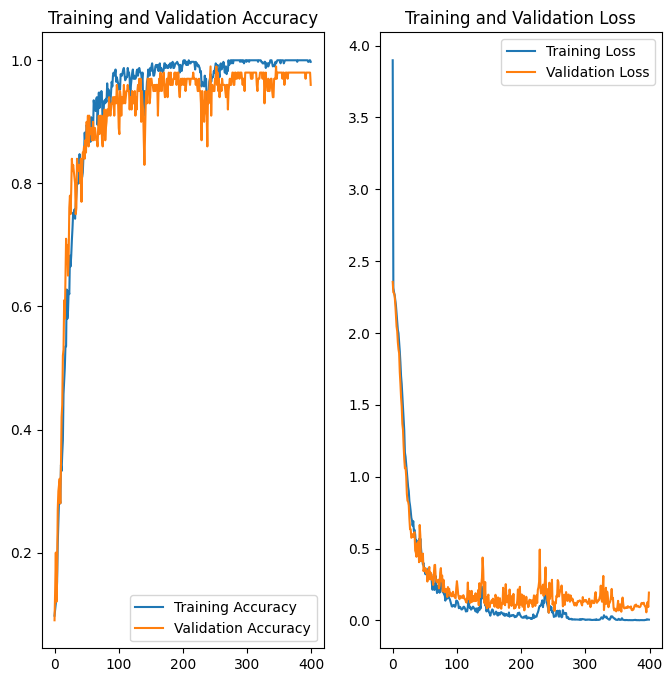

In [15]:
#En esta parte se extraen los datos del accuracy y loss para graficarlos y ver como se comporta el modelo
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)
                
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


In [16]:
#Este trozo de codigo es completamente opcional para ejecutar, aqui solo cargamos una imagen y predecimos que es
coin_path = "./p.jpg"
img = tf.keras.utils.load_img(
    coin_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) 

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
This image most likely belongs to huevo with a 23.05 percent confidence.


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step


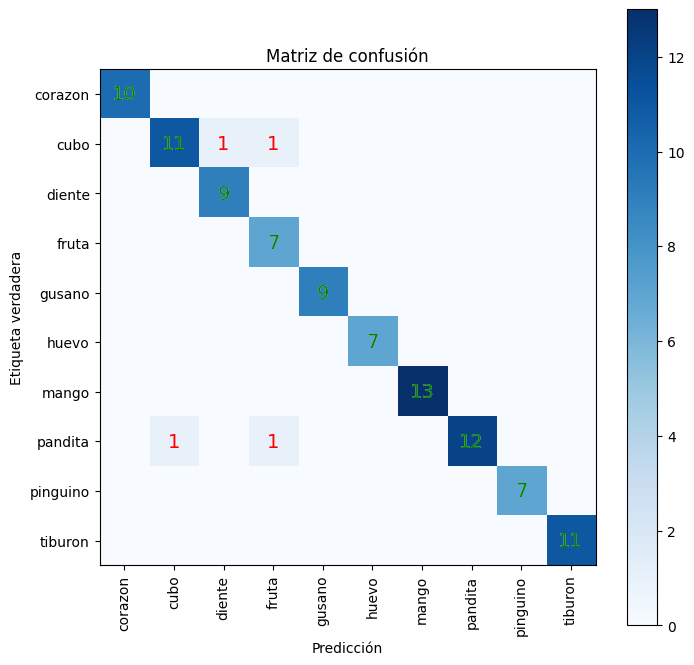

In [17]:
#Este trozo de codigo calcula una matriz de confusion para ver que tan bien se comporta el modelo

y_pred = np.argmax(model.predict(val_ds), axis=1)
y_true = np.concatenate([y for x, y in val_ds], axis=0)
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 

plt.figure(figsize=(8,8))
plt.imshow(confusion_mtx, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Matriz de confusión')
plt.colorbar()
tick_marks = np.arange(num_classes)
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicción')
plt.ylabel('Etiqueta verdadera')

correct_predictions = np.zeros(num_classes)
total_predictions = np.zeros(num_classes)
for i in range(len(y_true)):
    if y_true[i] == y_pred[i]:
        correct_predictions[y_true[i]] += 1
    total_predictions[y_true[i]] += 1
for i in range(num_classes):
    plt.text(i, i, int(correct_predictions[i]), ha="center", va="center", color="white", fontsize=14)
    for j in range(num_classes):
        if confusion_mtx[i, j] > 0 and i != j:
            plt.text(j, i, int(confusion_mtx[i, j]), ha="center", va="center", color="red", fontsize=14)
        if confusion_mtx[i, j] > 0 and i == j:
            plt.text(j, i, int(correct_predictions[i]), ha="center", va="center", color="green", fontsize=14)

plt.show()



In [18]:
#Con esta linea se guarda el modelo, simplemente hay que tener cuidado con el nombre, no queremos reemplazar el modelo anterior
model.save('gommodel.keras')